In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [2]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [3]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [4]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

In [5]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
columns_m = inspector.get_columns('measurement')
for c_m in columns_m:
    print(c_m['name'], c_m['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
date = dt.datetime(2016, 8, 23)
sel = [Measurement.date,
      func.avg(Measurement.prcp)]

last_52wks_prcp = session.query(*sel).\
    filter(Measurement.date > date).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

last_52wks_prcp

[('2016-08-24', 1.5549999999999997),
 ('2016-08-25', 0.07714285714285715),
 ('2016-08-26', 0.016666666666666666),
 ('2016-08-27', 0.06399999999999999),
 ('2016-08-28', 0.5166666666666666),
 ('2016-08-29', 0.24333333333333332),
 ('2016-08-30', 0.011666666666666667),
 ('2016-08-31', 0.6359999999999999),
 ('2016-09-01', 0.006),
 ('2016-09-02', 0.05),
 ('2016-09-03', 0.254),
 ('2016-09-04', 0.276),
 ('2016-09-05', 0.08499999999999999),
 ('2016-09-06', 0.246),
 ('2016-09-07', 0.3333333333333333),
 ('2016-09-08', 0.07666666666666667),
 ('2016-09-09', 0.17833333333333332),
 ('2016-09-10', 0.27999999999999997),
 ('2016-09-11', 0.25),
 ('2016-09-12', 0.308),
 ('2016-09-13', 0.45166666666666666),
 ('2016-09-14', 2.3800000000000003),
 ('2016-09-15', 0.8266666666666667),
 ('2016-09-16', 0.11714285714285715),
 ('2016-09-17', 0.13599999999999998),
 ('2016-09-18', 0.10600000000000001),
 ('2016-09-19', 0.064),
 ('2016-09-20', 0.14714285714285716),
 ('2016-09-21', 0.19499999999999998),
 ('2016-09-22', 

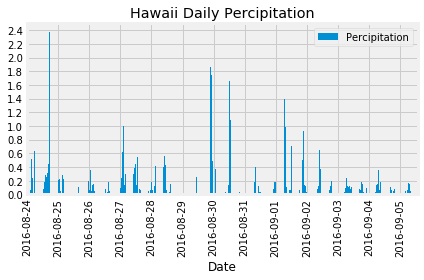

<Figure size 432x288 with 0 Axes>

In [30]:
percipitation = pd.DataFrame(last_52wks_prcp, columns=['date', 'Percipitation'])
percipitation.set_index('date', inplace=True)
percipitation.plot.bar()

plt.xlabel("Date")
plt.title("Hawaii Daily Percipitation")


plt.locator_params(nbins = 13)

plt.tight_layout()
plt.show()
plt.savefig("../sqlalchemy-challenge/percipitation")




In [17]:
columns_s = inspector.get_columns('station')
for c_s in columns_s:
    print(c_s['name'], c_s['type'])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).group_by(Station.station).count()
print(station_count)

9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query((Measurement.station), func.count(Measurement.station)).\
                  group_by(Measurement.station).\
                  order_by(func.count(Measurement.station).desc())

for active_station in active_stations:
    print(active_station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [20]:
# Identify most active station
most_active_stations = session.query(func.max(Measurement.station))

for most_active_station in most_active_stations:
    print(most_active_station)

('USC00519523',)


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

temps_most_active_station = session.query(func.min(Measurement.tobs), 
                                          func.max(Measurement.tobs),
                                          func.avg(Measurement.tobs)).\
                            filter(Measurement.station == most_active_stations).all()
                

for temp_most_active_station in temps_most_active_station:
    print(temp_most_active_station)

(56.0, 85.0, 74.5436493068565)


In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
date = dt.datetime(2016, 8, 23)
sel = [Measurement.station,
       Measurement.date,
      func.avg(Measurement.tobs)]

last_52wks_tobs = session.query(*sel).\
    filter(Measurement.date > date).filter(Measurement.station == most_active_stations).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

last_52wks_tobs

[('USC00519523', '2016-08-24', 79.0),
 ('USC00519523', '2016-08-25', 80.0),
 ('USC00519523', '2016-08-26', 84.0),
 ('USC00519523', '2016-08-27', 81.0),
 ('USC00519523', '2016-08-28', 80.0),
 ('USC00519523', '2016-08-29', 79.0),
 ('USC00519523', '2016-08-30', 78.0),
 ('USC00519523', '2016-08-31', 78.0),
 ('USC00519523', '2016-09-02', 81.0),
 ('USC00519523', '2016-09-03', 78.0),
 ('USC00519523', '2016-09-04', 84.0),
 ('USC00519523', '2016-09-05', 84.0),
 ('USC00519523', '2016-09-06', 78.0),
 ('USC00519523', '2016-09-07', 76.0),
 ('USC00519523', '2016-09-08', 79.0),
 ('USC00519523', '2016-09-09', 77.0),
 ('USC00519523', '2016-09-10', 78.0),
 ('USC00519523', '2016-09-11', 83.0),
 ('USC00519523', '2016-09-12', 78.0),
 ('USC00519523', '2016-09-13', 77.0),
 ('USC00519523', '2016-09-14', 77.0),
 ('USC00519523', '2016-09-15', 79.0),
 ('USC00519523', '2016-09-16', 78.0),
 ('USC00519523', '2016-09-17', 81.0),
 ('USC00519523', '2016-09-18', 81.0),
 ('USC00519523', '2016-09-19', 78.0),
 ('USC005195

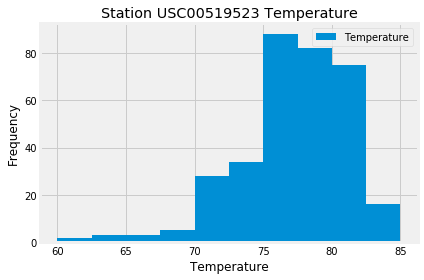

<Figure size 432x288 with 0 Axes>

In [26]:
temp = pd.DataFrame(last_52wks_tobs, columns=['station', 'date', 'Temperature'])
temp.set_index('date', inplace=True)
temp.plot.hist()

plt.xlabel("Temperature")
plt.title("Station USC00519523 Temperature")


plt.tight_layout()
plt.show()
plt.savefig("../sqlalchemy-challenge/temp")

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-08-24', '2017-08-23'))

[(58.0, 74.57894736842105, 87.0)]


In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp = pd.DataFrame(calc_temps, columns=['Min Temp', 'Max Temp', 'Avg Temp'])
temp.set_index('Min Temp', inplace=True)
temp.plot.bar()
plt.tight_layout()
plt.show()
plt.savefig("../sqlalchemy-challenge/calc_temps")

ValueError: DataFrame constructor not properly called!